In [15]:
import networkx as nx
bitcoin_df = pd.read_csv("desktop/bitcoin.csv", sep=",", header=None, names=["SOURCE", "TARGET", "RATING", "TIME"])

print(bitcoin_df.head())
print(bitcoin_df.info())

bitcoin_network = nx.DiGraph()
for _, row in bitcoin_df.iterrows():
    bitcoin_network.add_edge(row["SOURCE"], row["TARGET"], weight=row["RATING"])

print(f"Bitcoin Network: Nodes={bitcoin_network.number_of_nodes()}, Edges={bitcoin_network.number_of_edges()}")

   SOURCE  TARGET  RATING        TIME
0    7188       1      10  1407470400
1     430       1      10  1376539200
2    3134       1      10  1369713600
3    3026       1      10  1350014400
4    3010       1      10  1347854400
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24186 entries, 0 to 24185
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOURCE  24186 non-null  int64
 1   TARGET  24186 non-null  int64
 2   RATING  24186 non-null  int64
 3   TIME    24186 non-null  int64
dtypes: int64(4)
memory usage: 755.9 KB
None
Bitcoin Network: Nodes=3783, Edges=24186


Bitcoin Network:
{'num_nodes': 3783, 'num_edges': 24186, 'avg_degree': 12.786677240285488, 'clustering_coefficient': 0.17662903035907684, 'degree_assortativity': -0.16348431165342667, 'avg_shortest_path': 3.6485198322690042}

BA Network:
{'num_nodes': 3783, 'num_edges': 7562, 'avg_degree': 3.9978852762357917, 'clustering_coefficient': 0.010045431803308491, 'degree_assortativity': -0.058890782525867755, 'avg_shortest_path': 4.5907710368395}

WS Network:
{'num_nodes': 3783, 'num_edges': 7566, 'avg_degree': 4.0, 'clustering_coefficient': 0.37200760293543794, 'degree_assortativity': -0.00031231819287797294, 'avg_shortest_path': 10.856301109377265}

SBM Network:
{'num_nodes': 3782, 'num_edges': 393474, 'avg_degree': 208.0772078265468, 'clustering_coefficient': 0.08523010304399402, 'degree_assortativity': -0.004407534347763307, 'avg_shortest_path': 1.9562508190707217}

Comparison Table:
Nodes                     3783                 3783                 3783                 3782             

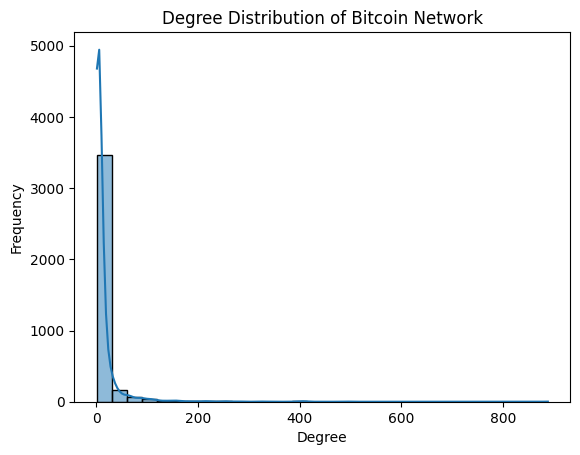

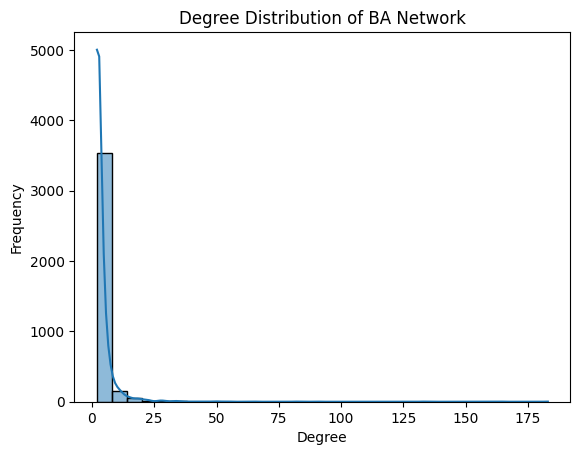

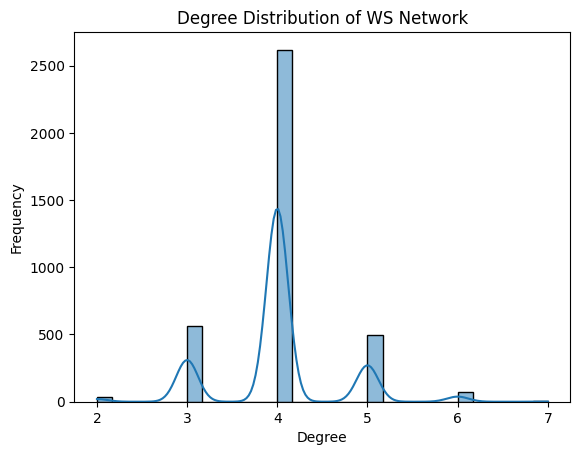

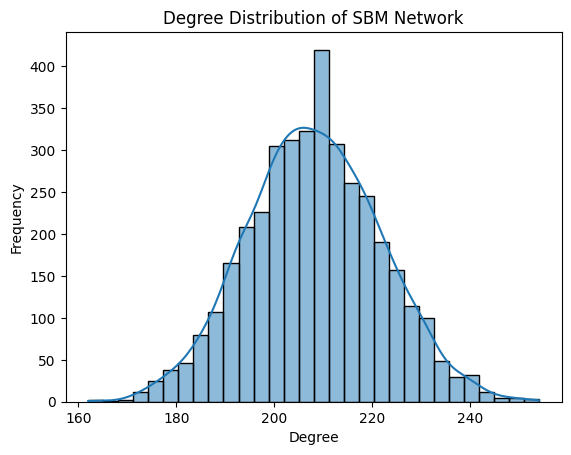

In [1]:
import networkx as nx
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from networkx.generators.community import stochastic_block_model
import seaborn as sns
import random

def load_bitcoin_network(file_path):
    df = pd.read_csv(file_path, header=None, names=["Source", "Target", "Weight", "Timestamp"])
    G = nx.from_pandas_edgelist(df, "Source", "Target", edge_attr="Weight", create_using=nx.DiGraph())
    return G

def calculate_macro_metrics(G):
    is_directed = G.is_directed() 
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": np.mean([d for n, d in G.degree()]),
        "clustering_coefficient": nx.average_clustering(G.to_undirected()),
        "degree_assortativity": nx.degree_assortativity_coefficient(G),
    }
    if is_directed:
        if nx.is_strongly_connected(G):
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G)
        else:
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            G_scc = G.subgraph(largest_scc).copy()
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G_scc)
    else:
        if nx.is_connected(G):
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            G_cc = G.subgraph(largest_cc).copy()
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G_cc)
    return metrics

def generate_ba_network(num_nodes, m):
    return nx.barabasi_albert_graph(num_nodes, m)

def generate_ws_network(num_nodes, k, p):
    return nx.watts_strogatz_graph(num_nodes, k, p)

def generate_sbm_network(num_nodes, num_communities, intra_prob, inter_prob):
    sizes = [num_nodes // num_communities] * num_communities
    probs = np.full((num_communities, num_communities), inter_prob)
    np.fill_diagonal(probs, intra_prob)
    return stochastic_block_model(sizes, probs)

def plot_degree_distribution(G, title):
    degrees = [d for n, d in G.degree()]
    sns.histplot(degrees, bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

def main():
    FILE_PATH = "desktop/bitcoin.csv"
    bitcoin_network = load_bitcoin_network(FILE_PATH)
    print("Bitcoin Network:")
    bitcoin_metrics = calculate_macro_metrics(bitcoin_network)
    print(bitcoin_metrics)

    G_ba = generate_ba_network(num_nodes=bitcoin_network.number_of_nodes(), m=2)
    G_ws = generate_ws_network(num_nodes=bitcoin_network.number_of_nodes(), k=4, p=0.1)
    G_sbm = generate_sbm_network(num_nodes=bitcoin_network.number_of_nodes(),
                                 num_communities=2, intra_prob=0.1, inter_prob=0.01)

    print("\nBA Network:")
    ba_metrics = calculate_macro_metrics(G_ba)
    print(ba_metrics)

    print("\nWS Network:")
    ws_metrics = calculate_macro_metrics(G_ws)
    print(ws_metrics)

    print("\nSBM Network:")
    sbm_metrics = calculate_macro_metrics(G_sbm)
    print(sbm_metrics)

    metrics_table = {
        "Metric": ["Nodes", "Edges", "Avg Degree", "Clustering Coefficient", "Degree Assortativity", "Avg Shortest Path"],
        "Bitcoin Network": [bitcoin_metrics["num_nodes"], bitcoin_metrics["num_edges"], bitcoin_metrics["avg_degree"],
                            bitcoin_metrics["clustering_coefficient"], bitcoin_metrics["degree_assortativity"],
                            bitcoin_metrics["avg_shortest_path"]],
        "BA Network": [ba_metrics["num_nodes"], ba_metrics["num_edges"], ba_metrics["avg_degree"],
                       ba_metrics["clustering_coefficient"], ba_metrics["degree_assortativity"],
                       ba_metrics["avg_shortest_path"]],
        "WS Network": [ws_metrics["num_nodes"], ws_metrics["num_edges"], ws_metrics["avg_degree"],
                       ws_metrics["clustering_coefficient"], ws_metrics["degree_assortativity"],
                       ws_metrics["avg_shortest_path"]],
        "SBM Network": [sbm_metrics["num_nodes"], sbm_metrics["num_edges"], sbm_metrics["avg_degree"],
                        sbm_metrics["clustering_coefficient"], sbm_metrics["degree_assortativity"],
                        sbm_metrics["avg_shortest_path"]]
    }

    print("\nComparison Table:")
    for i in range(len(metrics_table["Metric"])):
        print(f"{metrics_table['Metric'][i]:<25} "
              f"{metrics_table['Bitcoin Network'][i]:<20} "
              f"{metrics_table['BA Network'][i]:<20} "
              f"{metrics_table['WS Network'][i]:<20} "
              f"{metrics_table['SBM Network'][i]:<20}")

    plot_degree_distribution(bitcoin_network, "Degree Distribution of Bitcoin Network")
    plot_degree_distribution(G_ba, "Degree Distribution of BA Network")
    plot_degree_distribution(G_ws, "Degree Distribution of WS Network")
    plot_degree_distribution(G_sbm, "Degree Distribution of SBM Network")

if __name__ == "__main__":
    main()